# Прогнозирование покупательской активности постоянных клиентов и разработка решения для персонализации предложений.

Интернет-магазин ***«В один клик»*** продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и продукты. Отчёт за предыдущий период показал снижение покупательской активности, при этом привлечение новых клиентов стало менее эффективным, поскольку большая часть целевой аудитории уже знает о магазине. Возможное решение — удержание постоянных клиентов с помощью персонализированных предложений.  

Цель: повысить активность постоянных клиентов.  
Задача: разработать решение для персонализации предложений постоянным клиентам.

В нашем распоряжении четыре набора данных.  
`market_file` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- `id` — идентификатор покупателя;  
- `Покупательская активность` — класс покупательской активности (целевой признак): «снизилась» или «прежний уровень»;  
- `Тип сервиса` — уровень сервиса: «премиум» и «стандарт»;  
- `Разрешить сообщать` — можно ли присылать покупателю дополнительные предложения о товаре;  
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента;  
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце;  
- `Длительность` — сколько дней прошло с момента регистрации покупателя на сайте;  
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев;  
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев;  
- `Средний_просмотр_категорий_за_визит` — сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца;  
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца;  
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта;  
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.  


`market_money` отражает данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.  
- `id` — идентификатор покупателя;  
- `Период` — период, во время которого зафиксирована выручка (например, 'текущий_месяц' или 'предыдущий_месяц');  
- `Выручка` — сумма выручки за период.  
  
`market_time` - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода;  
- `id` — идентификатор покупателя;  
- `Период` — период, во время которого зафиксировано общее время;  
- `минут` — время, проведённое на сайте, в минутах;  
  
`money` данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.  
- `id` — идентификатор покупателя;  
- `Прибыль` — значение прибыли.

## Загрузка данных

In [ ]:
!pip install shap
!pip install phik
!pip install scikit-learn==1.5.2 -q
!pip install matplotlib==3.5.1 -q

     |████████████████████████████████| 539 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 686 kB 2.1 MB/s eta 0:00:01


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.model_selection import RandomizedSearchCV

import shap

RANDOM_STATE=42

In [ ]:
try:
    user_behavior = pd.read_csv('/datasets/market_file.csv', sep=',')
    revenue = pd.read_csv('/datasets/market_money.csv', sep=',')
    time = pd.read_csv('/datasets/market_time.csv', sep=',')
    profit = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
except:
    user_behavior = pd.read_csv('market_file.csv', sep=',')
    revenue = pd.read_csv('market_money.csv', sep=',')
    time = pd.read_csv('market_time.csv', sep=',')
    profit = pd.read_csv('money.csv', sep=';', decimal=',')

Проверим, корректно ли отображаются данные

In [ ]:
display(user_behavior.head())
display(revenue.head())
display(time.head())
display(profit.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Определим функцию для вывода основной информации о датасете

In [ ]:
def data_info(df):
    display(df.head(20))
    print()
    display(df.describe())
    print()
    df.info()

In [ ]:
data_info(user_behavior)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса               

Наименования столбцов содержат как строчные, так и заглавные буквы, типы данных указаны корректно

In [ ]:
data_info(revenue)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [ ]:
data_info(time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [ ]:
data_info(profit)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Для всех датасетов достаточно привести названия признаков к нижнему регистру, типы данных корректны, пропущенных значений не обнаружено.

## Предобработка данных

### Переименование признаков

Выведем столбцы датасетов:

In [ ]:
print('user_behavior:\n', user_behavior.columns)
print()
print('revenue:\n', revenue.columns)
print()
print('time:\n', time.columns)
print()
print('profit:\n', profit.columns)

user_behavior:
 Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

revenue:
 Index(['id', 'Период', 'Выручка'], dtype='object')

time:
 Index(['id', 'Период', 'минут'], dtype='object')

profit:
 Index(['id', 'Прибыль'], dtype='object')


Для удобства дальнейшей работы приведём наименования к нижнему регистру

In [ ]:
for df in [user_behavior, revenue, time, profit]:
    df.columns = df.columns.str.lower()

Также, избавимся от пробелов

In [ ]:
user_behavior.columns = user_behavior.columns.str.replace(' ', '_')

Выведем преобразованные названия признаков

In [ ]:
print('user_behavior:\n', user_behavior.columns)
print()
print('revenue:\n', revenue.columns)
print()
print('time:\n', time.columns)
print()
print('profit:\n', profit.columns)

user_behavior:
 Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

revenue:
 Index(['id', 'период', 'выручка'], dtype='object')

time:
 Index(['id', 'период', 'минут'], dtype='object')

profit:
 Index(['id', 'прибыль'], dtype='object')


### Обработка дубликатов

In [ ]:
for name, df in [['user_behavior', user_behavior], ['revenue', revenue], ['time', time]]:
    print(f'Датасет {name}:')
    for i in df.select_dtypes(object).columns:
        print(f'Уникальные значения признака "{i}":')
        print(df[i].unique())
        print()

Датасет user_behavior:
Уникальные значения признака "покупательская_активность":
['Снизилась' 'Прежний уровень']

Уникальные значения признака "тип_сервиса":
['премиум' 'стандартт' 'стандарт']

Уникальные значения признака "разрешить_сообщать":
['да' 'нет']

Уникальные значения признака "популярная_категория":
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

Датасет revenue:
Уникальные значения признака "период":
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

Датасет time:
Уникальные значения признака "период":
['текущий_месяц' 'предыдцщий_месяц']



Обнаружено повторяющееся значение в столбце `тип_сервиса` (`стандарт` и `стандартт`), а также некорректное написание значения `предыдцщий_месяц` признака `период` в датасете `time`. Под `препредыдущим` периодом в `revenue`, вероятно подразумевается `предпредыдущий`. Исправим неточности:  

In [ ]:
user_behavior['тип_сервиса'] = user_behavior['тип_сервиса'].replace('стандартт', 'стандарт')
revenue['период'] = revenue['период'].replace('препредыдущий_месяц', 'предпредыдущий_месяц')
time['период'] = time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

Повторно выведем значения признаков

In [ ]:
for name, df in [['user_behavior', user_behavior], ['revenue', revenue], ['time', time]]:
    print(f'Датасет {name}:')
    for i in df.select_dtypes(object).columns:
        print(f'Уникальные значения признака "{i}":')
        print(df[i].unique())
        print()

Датасет user_behavior:
Уникальные значения признака "покупательская_активность":
['Снизилась' 'Прежний уровень']

Уникальные значения признака "тип_сервиса":
['премиум' 'стандарт']

Уникальные значения признака "разрешить_сообщать":
['да' 'нет']

Уникальные значения признака "популярная_категория":
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

Датасет revenue:
Уникальные значения признака "период":
['предпредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

Датасет time:
Уникальные значения признака "период":
['текущий_месяц' 'предыдущий_месяц']



Проверим наличие явных дубликатов

In [ ]:
print('Количество явных дубликатов:')
print(f'user_behavior - {user_behavior.duplicated(keep=False).sum()}')
print(f'revenue - {revenue.duplicated(keep=False).sum()}')
print(f'time - {time.duplicated(keep=False).sum()}')
print(f'profit - {profit.duplicated(keep=False).sum()}')

Количество явных дубликатов:
user_behavior - 0
revenue - 0
time - 0
profit - 0


Явных дубликатов не обнаружено

### Промежуточный вывод

В ходе предобработки данных были переименованы признаки, содержащие пробелы и буквы разного регистра, а также исправлены некорректные написания значений признаков.

## Исследовательский анализ данных

Отберём клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

In [ ]:
users_revenue = revenue[revenue['выручка'] == 0]['id'].unique()
revenue[revenue['id'].isin(users_revenue)]

,id,период,выручка
0,215348,предпредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
27,215357,текущий_месяц,5986.3
28,215357,предпредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
33,215359,текущий_месяц,4735.0
34,215359,предыдущий_месяц,0.0
35,215359,предпредыдущий_месяц,0.0


Есть три клиента, которые покупали товары только в текущем месяце. Вероятно, это новые клиенты, и так как нет информации за предыдущие периоды, не удастся предсказать паттерн поведения.

In [ ]:
user_behavior = user_behavior[~(user_behavior['id'].isin(users_revenue))]
revenue = revenue[~(revenue['id'].isin(users_revenue))]
time = time[~(time['id'].isin(users_revenue))]
profit = profit[~(profit['id'].isin(users_revenue))]

In [ ]:
print(user_behavior.shape)
print(revenue.shape)
print(time.shape)
print(profit.shape)

(1297, 13)
(3891, 3)
(2594, 3)
(1297, 2)


Определим функцию для визуализации распределений количественных признаков и вывода описательной статистики

In [ ]:
def num_features_stats(feature, feature_name, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle(title, fontsize=16)

    # Гистограмма
    sns.histplot(x=feature, kde=True, ax=ax[0])
    ax[0].set_title('Распределение данных')
    ax[0].set_xlabel(feature_name)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)

    # Диаграмма размаха
    sns.boxplot(x=feature, ax=ax[1])
    ax[1].set_title('Диаграмма размаха')
    ax[1].set_xlabel(feature_name)
    ax[1].grid(True)

    plt.show()

    print()
    print('Описательная статистика')
    print(feature.describe())

И для визуализации распределений категориальных признаков:

In [ ]:
def cat_features_stats(feature, feature_name, title):

    sns.set(style='whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle(title, fontsize=16)

    sns.countplot(y=feature, ax=ax[0], order = feature.value_counts().index)
    ax[0].set_title('Столбчатая диаграмма')
    ax[0].set_ylabel(feature_name)
    ax[0].set_xlabel('Количество наблюдений')
    ax[0].tick_params(axis='y', rotation=45)
    ax[0].grid(False)


    # Построение круговой диаграммы без подписей
    wedges, texts, autotexts = ax[1].pie(
        feature.value_counts(ascending=False),
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'linewidth': 3, 'edgecolor': 'white'}
    )
    ax[1].set_title('Круговая диаграмма')
    ax[1].set_ylabel(None)

    # Добавление легенды
    ax[1].legend(wedges,
                 feature.value_counts(ascending=False).index,
                 title=feature_name,
                 loc="center left",
                 bbox_to_anchor=(1, 0, 0.5, 1))

    plt.show()

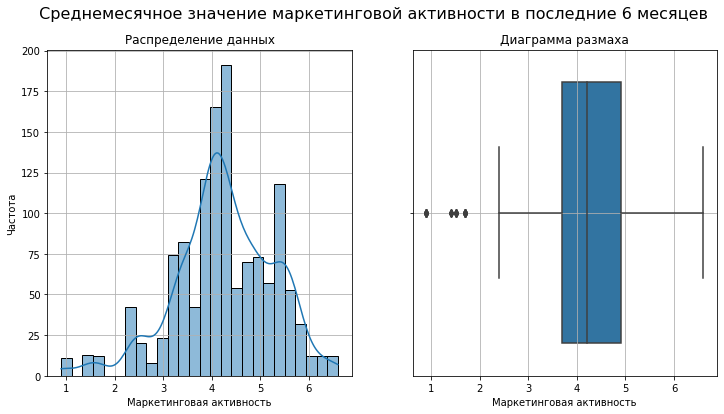


Описательная статистика
count    1297.000000
mean        4.254433
std         1.015618
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64


In [ ]:
num_features_stats(user_behavior['маркет_актив_6_мес'],
                   'Маркетинговая активность',
                   ' Среднемесячное значение маркетинговой активности в последние 6 месяцев')

Среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние полгода, составляет для большинства наблюдений от 3 до 6 коммуникаций, при этом наибольшее количество наблюдений сосредоточено в районе значения 4.

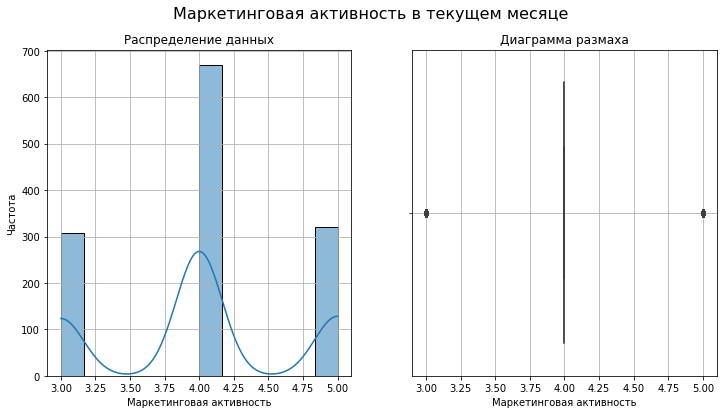


Описательная статистика
count    1297.000000
mean        4.009252
std         0.696048
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64


In [ ]:
num_features_stats(user_behavior['маркет_актив_тек_мес'],
                   'Маркетинговая активность',
                   'Маркетинговая активность в текущем месяце')

In [ ]:
user_behavior['маркет_актив_тек_мес'].value_counts()

4    669
5    320
3    308
Name: маркет_актив_тек_мес, dtype: int64

Маркетинговая активность в текущем месяце варьируется от 3 до 5, при этом более чем для 50% покупателей показатель составляет 4 коммуникации.

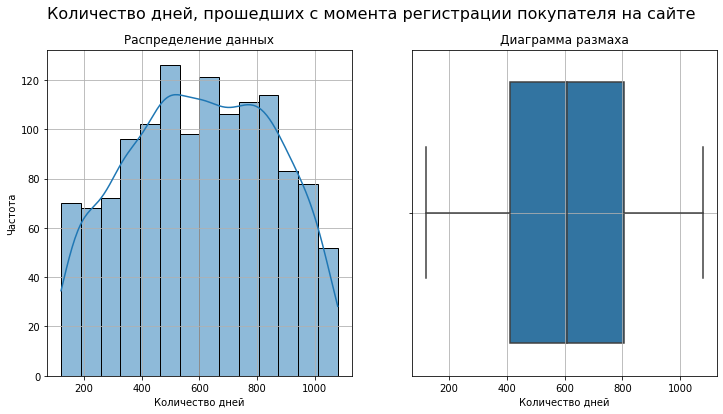


Описательная статистика
count    1297.000000
mean      602.993832
std       249.101456
min       121.000000
25%       410.000000
50%       607.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64


In [ ]:
num_features_stats(user_behavior['длительность'],
                   'Количество дней',
                   'Количество дней, прошедших с момента регистрации покупателя на сайте')

Покупатели, которые представленны в выборке, зарегистрированы на сайте от 4 месяцев до 3 лет, при этом 75% пользователей прошли регистрацию более чем 410 дней (1 год и 1,5 месяца) назад.

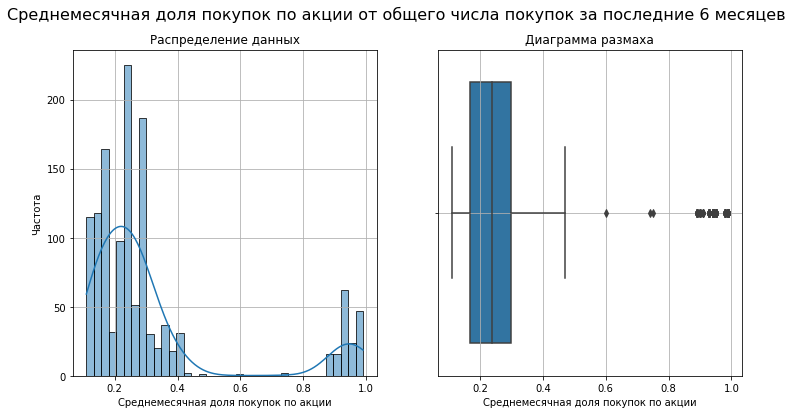


Описательная статистика
count    1297.000000
mean        0.320547
std         0.249657
min         0.110000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64


In [ ]:
num_features_stats(user_behavior['акционные_покупки'],
                   'Среднемесячная доля покупок по акции',
                   'Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев')

Для 75% покупателей средняя доля покупок по акции не превышает 30% от общего числа покупок, однако есть группа клиентов, которые большую часть покупок совершают по акции.  
Рассмотрим эти группы пользователей отдельно:

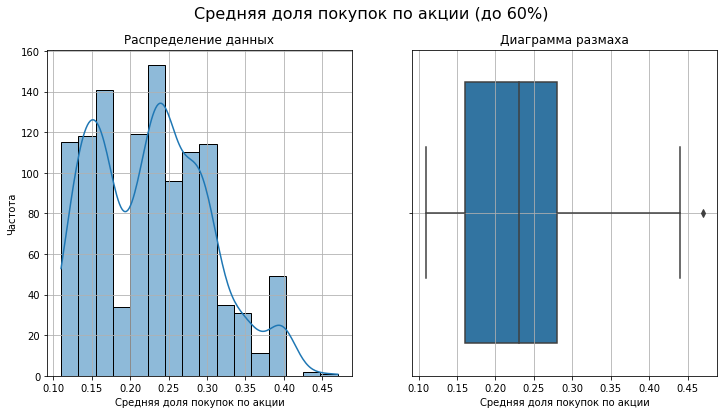


Описательная статистика
count    1129.000000
mean        0.228273
std         0.074158
min         0.110000
25%         0.160000
50%         0.230000
75%         0.280000
max         0.470000
Name: акционные_покупки, dtype: float64


In [ ]:
num_features_stats(user_behavior.query('акционные_покупки < 0.6')['акционные_покупки'],
                   'Средняя доля покупок по акции',
                   'Средняя доля покупок по акции (до 60%)')

Среди покупателей, которые совершают покупки по акции иногда, доля акционных покупок в среднем составляет 23%.

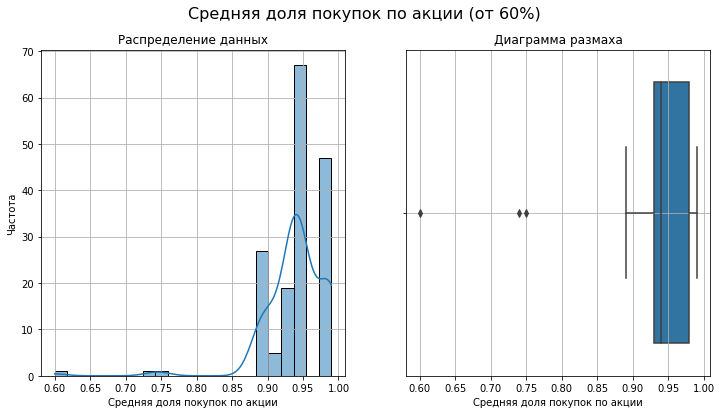


Описательная статистика
count    168.000000
mean       0.940655
std        0.046444
min        0.600000
25%        0.930000
50%        0.940000
75%        0.980000
max        0.990000
Name: акционные_покупки, dtype: float64


In [ ]:
num_features_stats(user_behavior.query('акционные_покупки >= 0.6')['акционные_покупки'],
                   'Средняя доля покупок по акции',
                   'Средняя доля покупок по акции (от 60%)')

Среди тех, кто совершает покупки преимущественно по акции, у 3/4 пользователей доля акционных покупок составляет от 93%, а у 1/4 и вовсе не менее 98%.

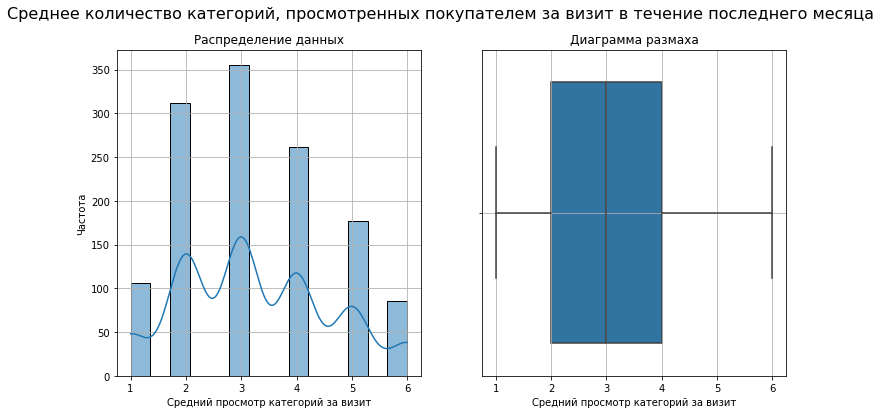


Описательная статистика
count    1297.000000
mean        3.267540
std         1.354623
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64


In [ ]:
num_features_stats(user_behavior['средний_просмотр_категорий_за_визит'],
                   'Средний просмотр категорий за визит',
                   'Среднее количество категорий, просмотренных покупателем за визит в течение последнего месяца')

В среднем за визит большая часть покупателей просматривает 2-4 категории товаров.

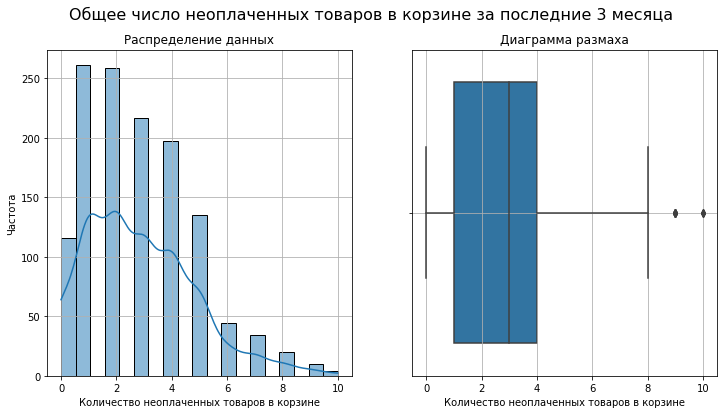


Описательная статистика
count    1297.000000
mean        2.841172
std         1.973451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


In [ ]:
num_features_stats(user_behavior['неоплаченные_продукты_штук_квартал'],
                   'Количество неоплаченных товаров в корзине',
                   'Общее число неоплаченных товаров в корзине за последние 3 месяца')

75% покупателей отложили в корзину и не оплатили до 4 товаров за последние 3 месяца, чаще всего неоплаченнымы в корзине лежат 1-2 товара.

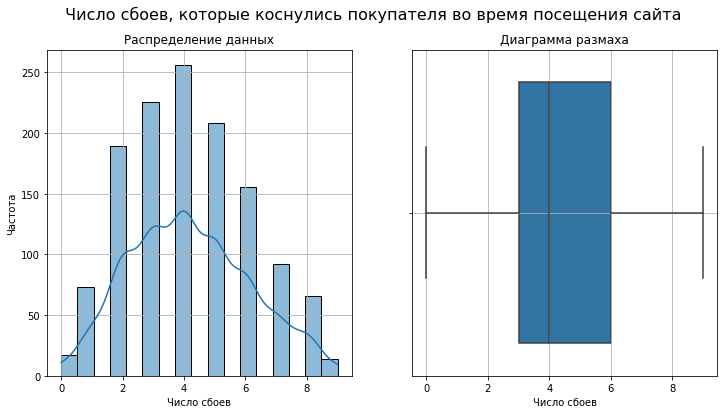


Описательная статистика
count    1297.000000
mean        4.184271
std         1.950973
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64


In [ ]:
num_features_stats(user_behavior['ошибка_сервиса'],
                   'Число сбоев',
                   ' Число сбоев, которые коснулись покупателя во время посещения сайта')

Большая часть клиентов сталкивается со сбоями в работе сайта от 2 до 6 раз, при
этом очень невелика доля тех, кого сбои не коснулись.

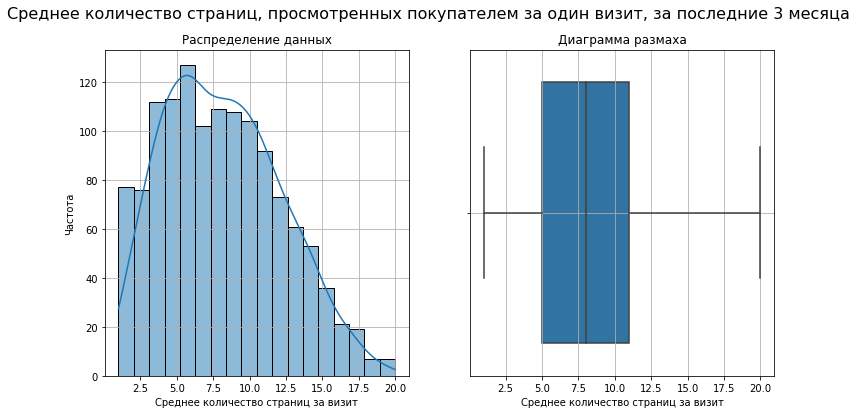


Описательная статистика
count    1297.000000
mean        8.186584
std         3.977061
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64


In [ ]:
num_features_stats(user_behavior['страниц_за_визит'],
                   'Среднее количество страниц за визит',
                   'Среднее количество страниц, просмотренных покупателем за один визит, за последние 3 месяца')

Половина клиентов просматривает в среднем до 8 страниц за визит, большая часть пользователей посещает в среднем от 3 до 11 страниц.

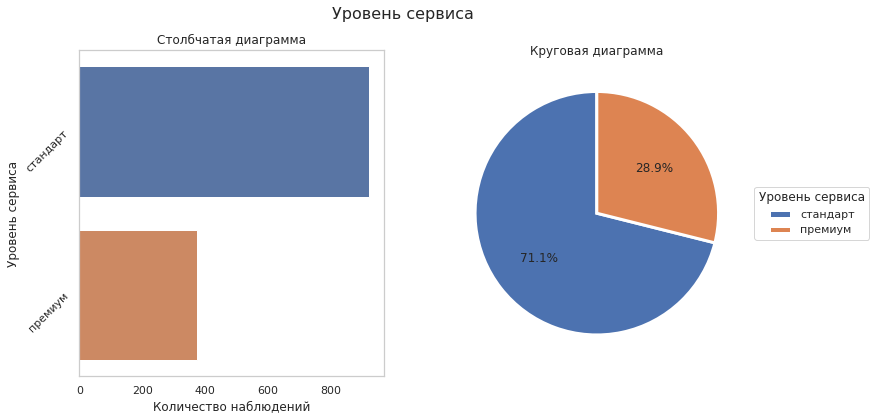

In [ ]:
cat_features_stats(user_behavior['тип_сервиса'],
                   'Уровень сервиса',
                   'Уровень сервиса')

В наборе данных преставлены по большей части клиенты сервиса `стандарт` (71,1%).

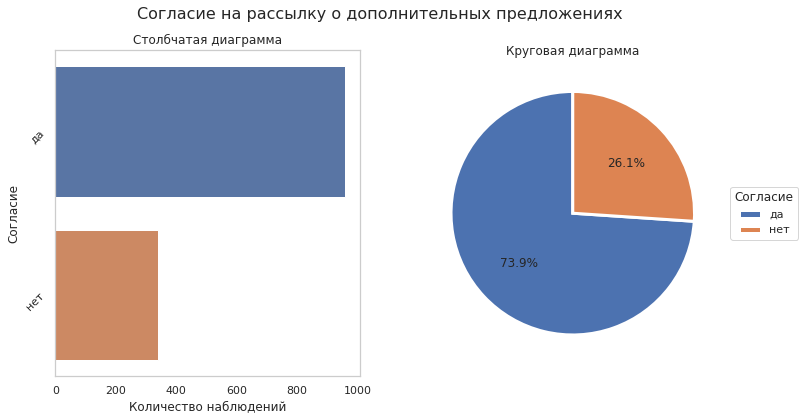

In [ ]:
cat_features_stats(user_behavior['разрешить_сообщать'],
                   'Согласие',
                   'Согласие на рассылку о дополнительных предложениях')

Почти 3/4 покупателей (74%) дали согласие на рассылку о дополнительных предложениях товаров.

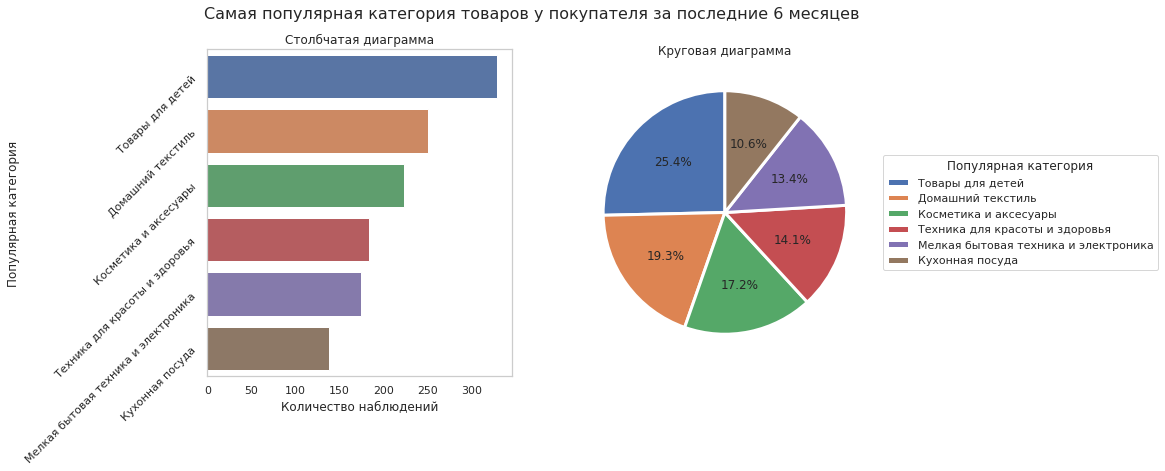

In [ ]:
cat_features_stats(user_behavior['популярная_категория'],
                   'Популярная категория',
                   'Самая популярная категория товаров у покупателя за последние 6 месяцев')

Наиболее популярной среди покупателей категорией являются `Товары для детей` (25,4%), `Домашний текстиль` (19,3%) и `Косметика и аксесуары` (17,2%). `Кухонная посуда`, напротив, пользуется наименьшим спросом (10.6%).

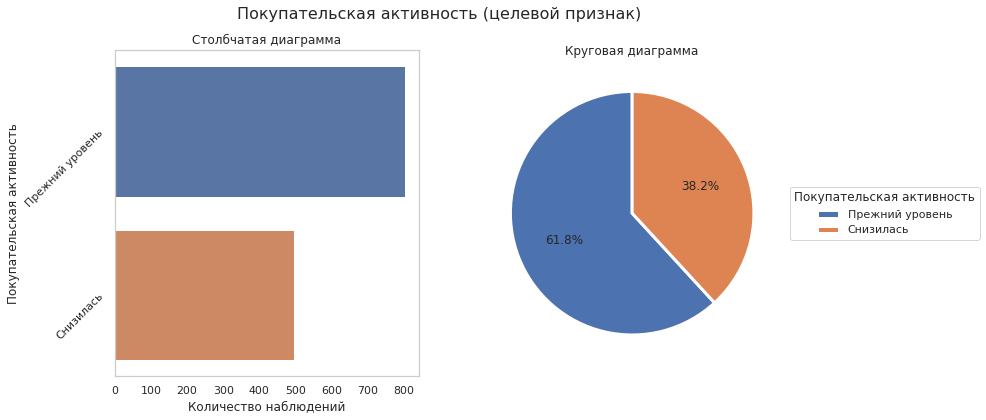

In [ ]:
cat_features_stats(user_behavior['покупательская_активность'], 'Покупательская активность', 'Покупательская активность (целевой признак)')

Целевой признак распределён неравномерно: в выборке преставлено 61,8% клиентов, покупательская активность которых осталась на прежнем уровне, и 38,2% покупателей, чья активность снизилась, разница составляет 23,6 процентных пункта.

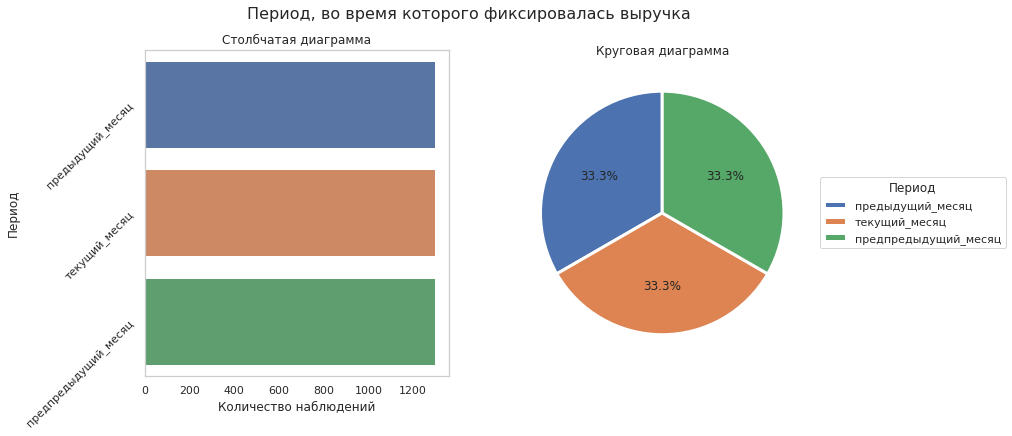

In [ ]:
cat_features_stats(revenue['период'],
                   'Период',
                   'Период, во время которого фиксировалась выручка')

Данные о выручке представлены равномерно по всем трём периодам

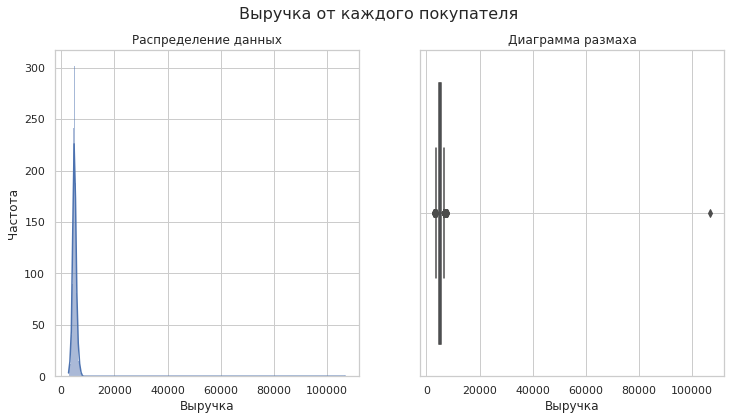


Описательная статистика
count      3891.000000
mean       5033.718890
std        1768.471286
min        2758.700000
25%        4592.000000
50%        4959.000000
75%        5363.200000
max      106862.200000
Name: выручка, dtype: float64


In [ ]:
num_features_stats(revenue['выручка'],
                   'Выручка',
                   'Выручка от каждого покупателя')

Очевиден выброс со значением 106 862.2, выведем это значение:

In [ ]:
revenue[revenue['id'].isin(revenue[revenue['выручка'] > 10000]['id'].to_list())]

,id,период,выручка
96,215380,предпредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


По прочим периодам значения выручки выглядят правдоподобно, удалим только аномально большое значение

In [ ]:
revenue = revenue.query('выручка < 10000')

Повторно выведем распределение данных о выручке после удаления аномалии

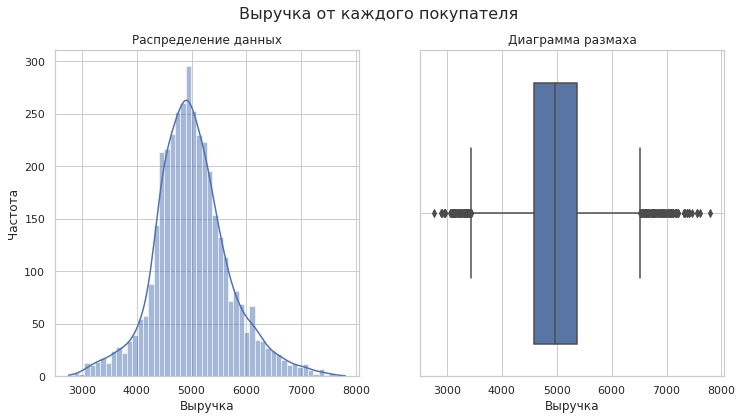


Описательная статистика
count    3890.000000
mean     5007.541902
std       679.235737
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64


In [ ]:
num_features_stats(revenue['выручка'],
                   'Выручка',
                   'Выручка от каждого покупателя')

Наблюдения распределены нормально, выручка в среднем составляет 5 007,54, основная масса данных распределенна от 4 000 до 6 000, оданко есть и существенное количество значений, выходящих за эти границы.

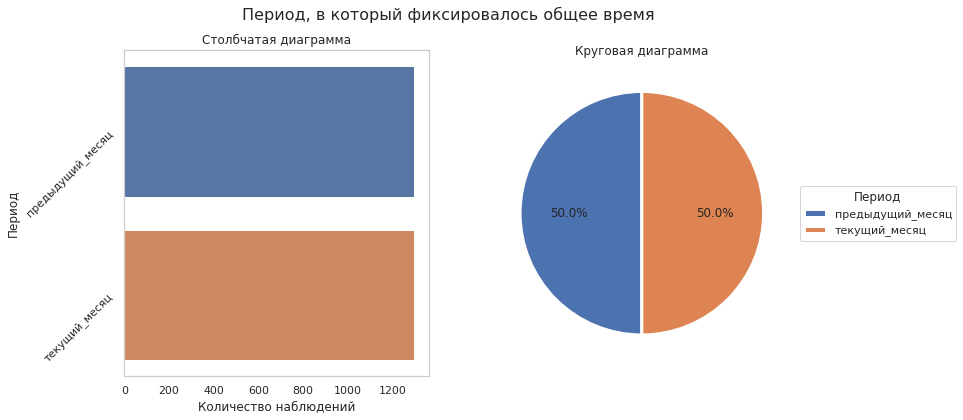

In [ ]:
cat_features_stats(time['период'],
                   'Период',
                   'Период, в который фиксировалось общее время')

Данные об общем времени также фиксировались равномерно как в предыдущем, так и в текущем месяце по 50%.

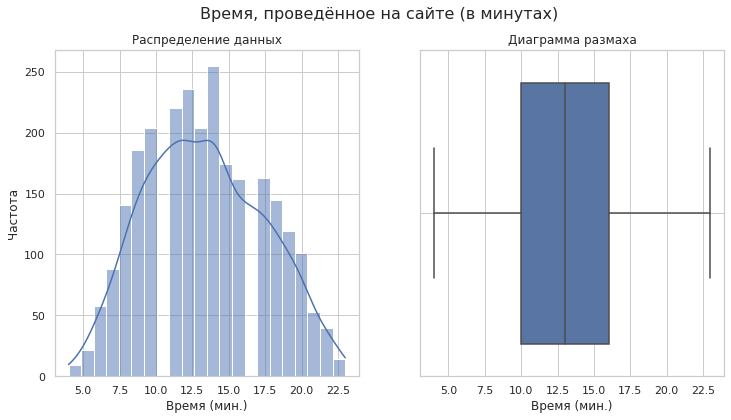


Описательная статистика
count    2594.000000
mean       13.340401
std         4.081999
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


In [ ]:
num_features_stats(time['минут'],
                   'Время (мин.)',
                   'Время, проведённое на сайте (в минутах)')

Пользовастели проводили на сайте не более 23 минут, при этом 75% покупателей проводили более 10 минут.

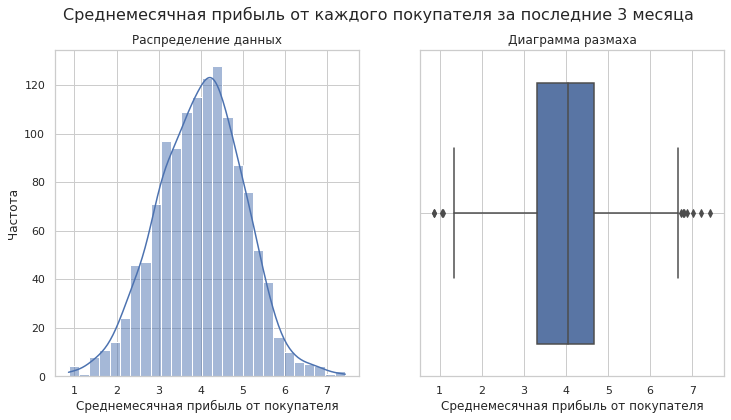


Описательная статистика
count    1297.000000
mean        3.997610
std         1.010813
min         0.860000
25%         3.300000
50%         4.040000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64


In [ ]:
num_features_stats(profit['прибыль'],
                   'Среднемесячная прибыль от покупателя',
                   'Среднемесячная прибыль от каждого покупателя за последние 3 месяца')

Данные о прибыли, как и о выручке, распределены нормально. Среднемесячная прибыль за последние 3 месяца в среднем составляет 4, при этом прибыль от 50% покупателей составляет от 3,3 до 4,67.  

### Промежуточный вывод

Данные о выручке и времени, проведённом на сайте, распределенны равномерно по периодам, за которые они представлены, прибыль и выручка имеют нормальное распределение, среднемесячная прибыль с каждого покупателя за последние три месяца в среднем составляет 3,998. Маркетинговая активность магазина составляет 3-5 коммуникаций за период, а на сайте покупатели проводят в основном от 7 до 20 минут, при этом просмотривают 2-4 категории товаров и в среднем около 8 страниц за визит. Есть группа клиентов, которые покупают товары преимущественно по скидкам (93% - 99% от общего числа покупок), у остальных пользователей доля акционных покупок составляет в основном до 40%. Наиболее популярными катеогриями товаров являются `Товары для детей`, `домашний текстиль`, `Косметика и аксесуары`, а наименее распространённой - `Кухонная посуда`.

## Объединение таблиц

Для дальнейшей работы объединим таблицы о поведении пользователей, выручке и времени, проведённом на сайте. Но перед этим разделим данные о выручке и времени по периодам на отдельные столбцы.

In [ ]:
revenue_pivot = revenue.pivot_table(index='id', columns='период', values='выручка', aggfunc='first').reset_index()
time_pivot = time.pivot_table(index='id', columns='период', values='минут', aggfunc='first').reset_index()

display(revenue_pivot.head(5))
display(time_pivot.head(5))

период,id,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц
0,215349,4472.0,5216.0,4971.6
1,215350,4826.0,5457.5,5058.4
2,215351,4793.0,6158.0,6610.4
3,215352,4594.0,5807.5,5872.5
4,215353,5124.0,4738.5,5388.5


период,id,предыдущий_месяц,текущий_месяц
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10


In [ ]:
revenue_pivot.columns = ['id', 'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']
time_pivot.columns = ['id', 'минут_в_предыдущем_месяце', 'минут_в_текущем_месяце']

display(revenue_pivot.head(5))
display(time_pivot.head(5))

,id,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215349,4472.0,5216.0,4971.6
1,215350,4826.0,5457.5,5058.4
2,215351,4793.0,6158.0,6610.4
3,215352,4594.0,5807.5,5872.5
4,215353,5124.0,4738.5,5388.5


,id,минут_в_предыдущем_месяце,минут_в_текущем_месяце
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10


Проверим размерности получившихся наборов данных:

In [ ]:
print(user_behavior.shape)
print(revenue_pivot.shape)
print(time_pivot.shape)
print(profit.shape)

(1297, 13)
(1297, 4)
(1297, 3)
(1297, 2)


Объединяем датафреймы:

In [ ]:
df = pd.merge(user_behavior,
              pd.merge(revenue_pivot,
                       time_pivot,
                       on='id'),
              on='id')
df.head(10)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_в_предыдущем_месяце,минут_в_текущем_месяце
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10
5,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,4503.0,5685.0,5869.6,11,12
6,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,4749.0,3263.0,3772.6,12,10
7,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4433.0,4146.5,4566.4,6,7
8,215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,4727.0,3488.0,4209.5,14,10
9,215360,Снизилась,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,5555.0,5304.5,5834.9,9,6


In [ ]:
df = df.set_index('id')

## Корреляционный анализ

Проведём корреляционный анализ признаков в количественной шкале. Так как не все признаки распределены нормально, а также есть выбросы, будем рассчитывать коэффициент Спирмена:

In [ ]:
df.select_dtypes([float, int]).corr(method='spearman').style.background_gradient(cmap ='coolwarm')

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_в_предыдущем_месяце,минут_в_текущем_месяце
маркет_актив_6_мес,1.000000,0.061697,-0.044614,-0.277968,0.185027,-0.134368,0.038656,0.319918,0.233325,-0.005652,0.002093,0.274003,0.226345
маркет_актив_тек_мес,0.061697,1.000000,-0.131979,0.033045,-0.025158,0.061754,0.087351,0.003144,-0.039397,-0.027107,-0.011782,0.013538,-0.063044
длительность,-0.044614,-0.131979,1.000000,0.029186,-0.043150,-0.108822,0.103528,-0.034591,-0.039284,0.013739,0.015002,-0.124000,0.083035
акционные_покупки,-0.277968,0.033045,0.029186,1.000000,-0.203380,0.197624,-0.051590,-0.370853,-0.267790,0.007035,0.022255,-0.332743,-0.274693
средний_просмотр_категорий_за_визит,0.185027,-0.025158,-0.043150,-0.203380,1.000000,-0.251448,0.010034,0.267536,0.149619,-0.049596,-0.070716,0.148376,0.233358
неоплаченные_продукты_штук_квартал,-0.134368,0.061754,-0.108822,0.197624,-0.251448,1.000000,-0.098544,-0.165297,-0.249421,0.032958,0.061178,-0.183426,-0.214803
ошибка_сервиса,0.038656,0.087351,0.103528,-0.051590,0.010034,-0.098544,1.000000,0.104508,0.090105,0.035383,0.040477,0.196017,0.078089
страниц_за_визит,0.319918,0.003144,-0.034591,-0.370853,0.267536,-0.165297,0.104508,1.000000,0.311428,-0.067879,-0.049964,0.450913,0.298113
выручка_предпредыдущий_месяц,0.233325,-0.039397,-0.039284,-0.267790,0.149619,-0.249421,0.090105,0.311428,1.000000,0.308707,0.149944,0.348403,0.299989
выручка_предыдущий_месяц,-0.005652,-0.027107,0.013739,0.007035,-0.049596,0.032958,0.035383,-0.067879,0.308707,1.000000,0.879097,-0.084632,-0.082747


Между выручкой в предыдущем месяце и выручкой в текущем месяце высокое значение коэффициента корреляции (0,879). Проверим, нет ли мультиколлинеарности в данных, для этого воспользуемся коэффициентом инфляции дисперсии VIF из библиотеки statsmodels.

Проверим количество пропущенных значений:

In [ ]:
df.isna().sum()

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предпредыдущий_месяц           0
выручка_предыдущий_месяц               0
выручка_текущий_месяц                  1
минут_в_предыдущем_месяце              0
минут_в_текущем_месяце                 0
dtype: int64

Есть один пропуск, который образовался, когда мы удалили аномальное значение выручки. Удалим его:

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предпредыдущий_месяц           0
выручка_предыдущий_месяц               0
выручка_текущий_месяц                  0
минут_в_предыдущем_месяце              0
минут_в_текущем_месяце                 0
dtype: int64

Рассчитаем кожффициенты инфляции дисперсии VIF:

In [ ]:
# выделение количественных признаков и добавление константы
X = add_constant(df.select_dtypes([int, float]))

# расчет VIF для каждого признака
VIFs = pd.DataFrame()
VIFs['Variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

VIFs['VIF'] = VIFs['VIF'].round(3)

print(VIFs)

                               Variable      VIF
0                                 const  352.524
1                    маркет_актив_6_мес    1.221
2                  маркет_актив_тек_мес    1.045
3                          длительность    1.099
4                     акционные_покупки    1.186
5   средний_просмотр_категорий_за_визит    1.179
6    неоплаченные_продукты_штук_квартал    1.199
7                        ошибка_сервиса    1.079
8                      страниц_за_визит    1.418
9          выручка_предпредыдущий_месяц    1.612
10             выручка_предыдущий_месяц    4.263
11                выручка_текущий_месяц    3.896
12            минут_в_предыдущем_месяце    1.527
13               минут_в_текущем_месяце    1.321


Для всех количественных признаков значение VIF меньше 5, мультиколлинеарности не обнаружено.

## Создание и использование пайплайнов

Разделим данные на обучающую и тестовую выборку (так как целевой признак распределён неравномерно, используем стратификацию).

In [ ]:
X = df.drop(columns='покупательская_активность')
y = df['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

Закодируем целевой признак с помощью LabelEncoder()

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

Обозначим столбцы для кодирования OneHotEncoder() и OrdinalEncoder(), а также все количественные признаки

In [ ]:
ohe_col = ['разрешить_сообщать', 'популярная_категория']
ord_col = ['тип_сервиса']
num_col = np.array(X.select_dtypes([float, int]).columns)

Создадаим пайплайн для подготовки данных и обучений моделей (пропущенных значений в датасете нет):

In [ ]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', sparse_output=False), ohe_col),
        ('ord', OrdinalEncoder(), ord_col),
        ('num', MinMaxScaler(), num_col)
    ],
    remainder='passthrough'
)

final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Зададим модели и гиперпараметры для перебора

In [ ]:
param_distributions = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_split': range(2, 21),
        'models__max_features': range(1, 17),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1,30),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1,11),
        'models__penalty': ['l1', 'l2', 'elasticnet', None],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1,11),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    }
]

Подберём оптимальную модель и гиперпараметры с помощью RandomizedSearchCV(), для оценки качество моделей выберем метрику `roc_auc`, поскольку классы в датасете представлены в неравном соотношении, а данная метрика устойчива к дисбалансу классов. Помимо этого, метрика `roc-auc` учитывает разные пороги классификации и легко интерпретируема.  

In [ ]:
randomized_search = RandomizedSearchCV(
    final,
    param_distributions,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse_output=False),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               OrdinalEncoder(),
                                                                               ['тип_сервиса']),
                                                                              ('num',
                                                                               MinMaxScaler(),
                                                                               array(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'а...
                                         'models__penalty': ['l1', 'l2',
                                                             'elasticnet',
                                                             None],
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 11),
                                         'models__class_weight': [None,
                                                                  'balanced'],
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [ ]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['тип_сервиса']),
                                                 ('num', MinMaxScaler(),
                                                  array(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предпредыдущий_месяц',
       'выручка_предыдущий_месяц', 'выручка_текущий_месяц',
       'минут_в_предыдущем_месяце', 'минут_в_текущем_месяце'],
      dtype=object))])),
                ('models', SVC(C=9, probability=True, random_state=42))])

Оптимальной оказалась модель метода опорных векторов, с гиперпараметром C=9. Оценим качество модели:

In [ ]:
randomized_search.best_score_

0.8884346486982851

Достаточно высокое значение метрики roc-auc, сравним со значением на тестовой выборке:

In [ ]:
roc_auc_score(y_test, randomized_search.predict_proba(X_test)[:,1])

0.9160700562229502

Значение метрики на тестовой выборке выше, чем на тренировочной

## Анализ важности признаков

Оценим важность признаков с помощью метода SHAP и графиков.

In [ ]:
model = randomized_search.best_estimator_['models']
preprocessor = randomized_search.best_estimator_['preprocessor']
X_train_new = preprocessor.fit_transform(X_train)
X_test_new = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out())

X_test_sampled = shap.sample(X_test_new, 100)

explainer = shap.explainers.Permutation(model.predict_proba, shap.sample(X_train_new, 100))
shap_values = explainer(X_test_sampled)
shap_values = shap_values[..., 1]

PermutationExplainer explainer: 101it [01:24,  1.10it/s]                         


Построим график общей значимости признаков:

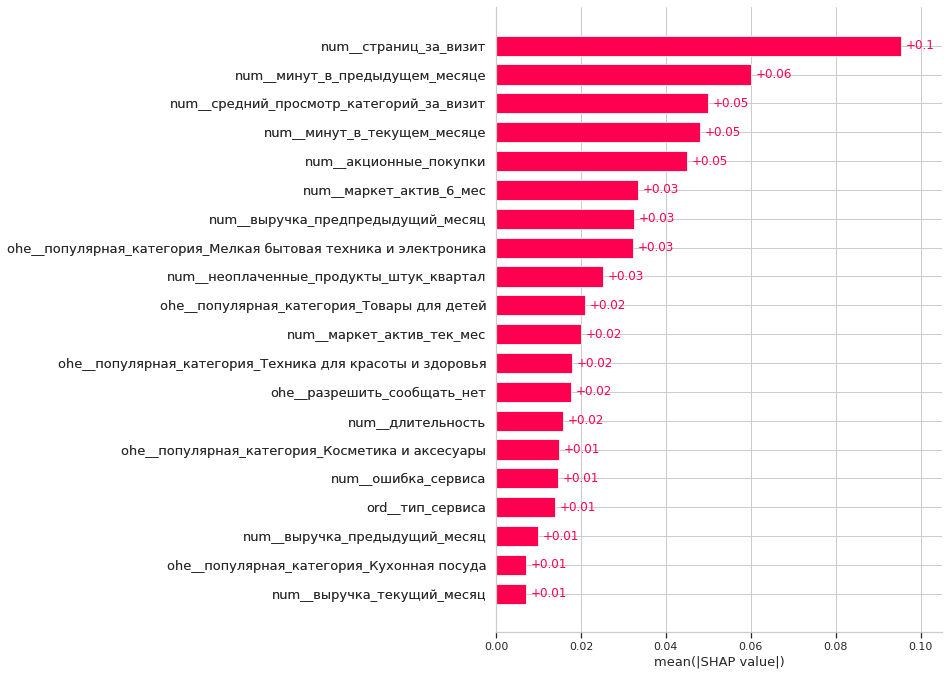

In [ ]:
shap.plots.bar(shap_values, max_display=21)

Ниболее значимыми признаками оказались: `страниц_за_визит`, `минут_в_предыдущем_месяце`, `акционные_покупки` `минут_в_текущем_месяце`, `средний_просмотр_категорий_за_визит`. Наименьшее влияние на целевой признак оказывают признаки `длительность` (отражающий, сколько дней прошло с момента регистрации покупателя на сайте), `выручка` (как в текущем месяце, так и в предыдущем), `ошибка_сервиса`.  

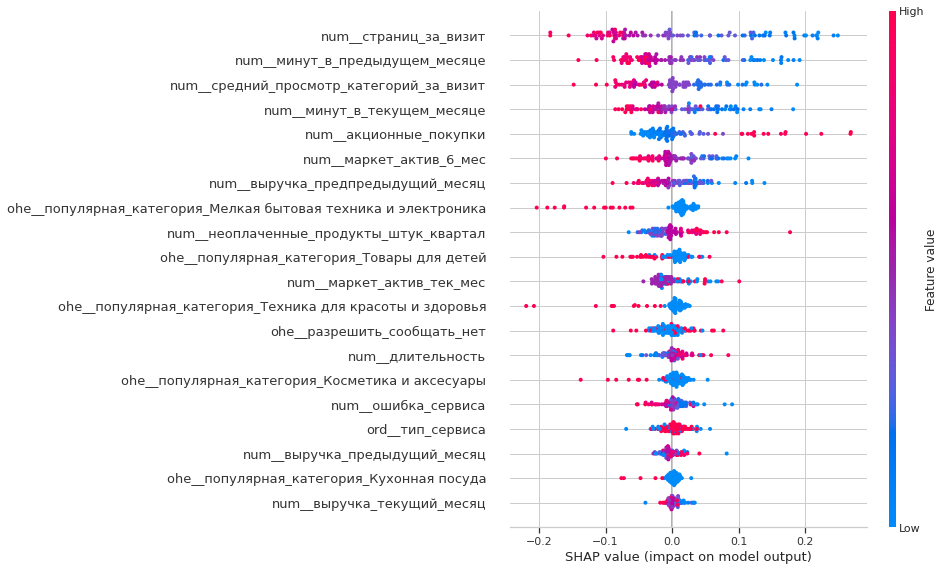

In [ ]:
shap.plots.beeswarm(shap_values, max_display=21)

Высокие значения `страниц_за_визит` склоняют модель отнести наблюдение к классу `Прежний уровень` и наоборот, если пользователь просматривал мало страниц, вероятно его покупательская активность снизится. Аналогично со `временем, проведённым на сайте` как `в предыдущем`, так и `в текущем месяце`, а также со `средним просмотром категорий за визит`. Обратная ситуация с признаком `акционные_покупки`: чем выше доля покупок по акции от общего объёма покупок, тем выше вероятность снижения покупательской активности. Также на графике видно группу клиентов, покупающих товары преимущественно по акции.

При моделировании и принятии решений следует обратить внимание на то, что особое значение имеет время, проведённое на сайте и количество просмотренных страниц и категорий, поэтому следует обратить особое внимание на наполнение сайта и постараться удержать внимание пользователя. Также, Следует обратить внимание на покупателей, предпочитающих в большей степени покупать только акционные товары, так как они наиболее склонны к снижению покупательской активности.

## Сегментация покупателей

### Выделение сегментов

Объединим данные о предсказанной вероятности снижения покупательской активности с тестовой выборкой

In [ ]:
df = df.drop(columns='покупательская_активность')
df_new = pd.DataFrame(preprocessor.fit_transform(df),
                          columns=preprocessor.get_feature_names_out())
df['y_prob'] = model.predict_proba(df_new)[:,1]
df_profit = df.merge(profit, on='id')

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [ ]:
df_profit.head()

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_в_предыдущем_месяце,минут_в_текущем_месяце,y_prob,прибыль
0,215349,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,0.863924,4.16
1,215350,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,0.834390,3.13
2,215351,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,0.871619,4.87
3,215352,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,0.834435,4.21
4,215353,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,0.900408,3.95


Построим граффик зависимости вероятности снижения покупательской активности и прибыли от клиента

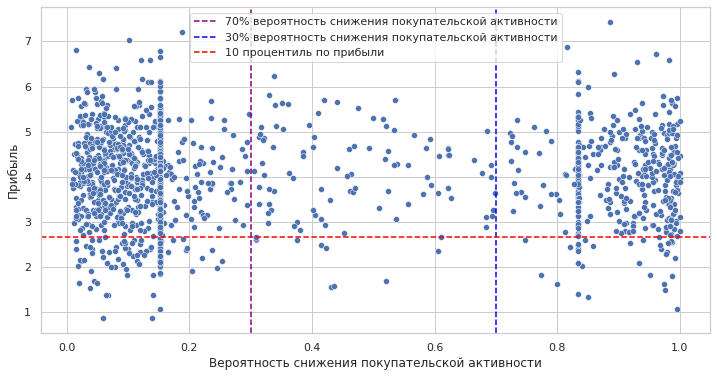

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_profit, x='y_prob', y='прибыль')
plt.axvline(0.3, linestyle='--', color='purple', label='70% вероятность снижения покупательской активности')
plt.axvline(0.7, linestyle='--', color='blue', label='30% вероятность снижения покупательской активности')
plt.axhline(np.percentile(df_profit['прибыль'], 10), linestyle='--', color='red', label='10 процентиль по прибыли')
plt.xlabel('Вероятность снижения покупательской активности')
plt.ylabel('Прибыль')
plt.legend()
plt.show()

Исключим из рассмотрения 10% наименее прибыльных клиентов, а оставшиеся 90% разделим на 3 сегмента:  
- вероятность снижения покупательской активности <= 30 (стабильные клиенты);  
- вероятность снижения покупательской активности от 30 до 70 (рисковые клиенты);  
- вероятность снижения покупательской активности >= 70 (критически рисковые клиенты)  

In [ ]:
df_segment = df_profit[df_profit['прибыль'] >= np.percentile(df_profit['прибыль'], 10)]

In [ ]:
df_segment.loc[:,'сегмент'] = df_segment['y_prob'].apply(lambda x: 'Стабильные' if x <= 0.3 else ('Рисковые' if 0.3 < x < 0.7 else 'Критические'))

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Анализ сегментов

Определим функцию для визуализации зависимости прибыли и вероятности снижения покупательской активности от признаков, оказывающих наиболее существенное влияние на целевую переменную.

In [ ]:
def segments_scatter(feature):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plt.suptitle(f'Диаграмма рассения для признака: "{feature}"', fontsize=16)

    sns.scatterplot(
        data=df_segment, y=feature, x='y_prob', hue='сегмент', ax=ax[0])
    ax[0].set_xlabel('Вероятность снижения покупательской активности')
    ax[0].set_ylabel(feature)
    ax[0].legend(loc='best')

    sns.scatterplot(
        data=df_segment, y=feature, x='прибыль', hue='сегмент', ax=ax[1])
    ax[1].set_xlabel('Прибыль')
    ax[1].set_ylabel(feature)
    ax[1].legend(loc='best')

    plt.show();
    print()
    print(f'Группировка по признаку: {feature}')
    print(df_segment.groupby('сегмент')[feature].describe())
    print()

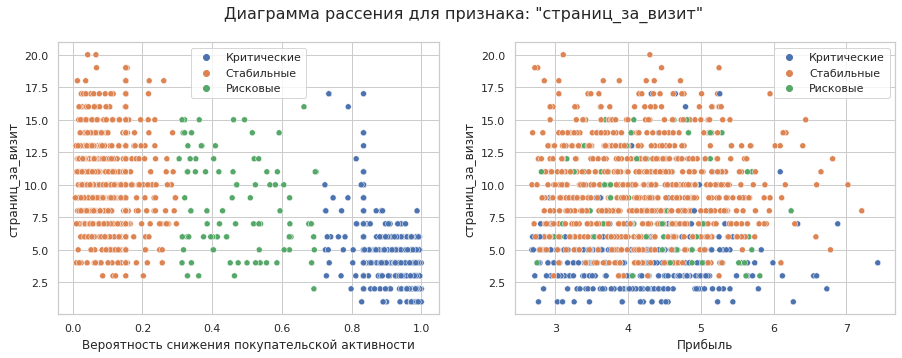


Группировка по признаку: страниц_за_визит
             count      mean       std  min  25%   50%   75%   max
сегмент                                                           
Критические  365.0  4.602740  2.559939  1.0  3.0   4.0   6.0  17.0
Рисковые      92.0  8.445652  3.614270  2.0  6.0   7.5  11.0  16.0
Стабильные   709.0  9.915374  3.393855  3.0  7.0  10.0  12.0  20.0



In [ ]:
segments_scatter('страниц_за_визит')


На графике, также, видим высокую вероятность снижения покупательской активности у клиентов, которые просматривают небольшое количество страниц за визит, и напротив - низкую вероятность снижения активности для сегмента стабильных клиентоа, которые просматривают больше страниц.

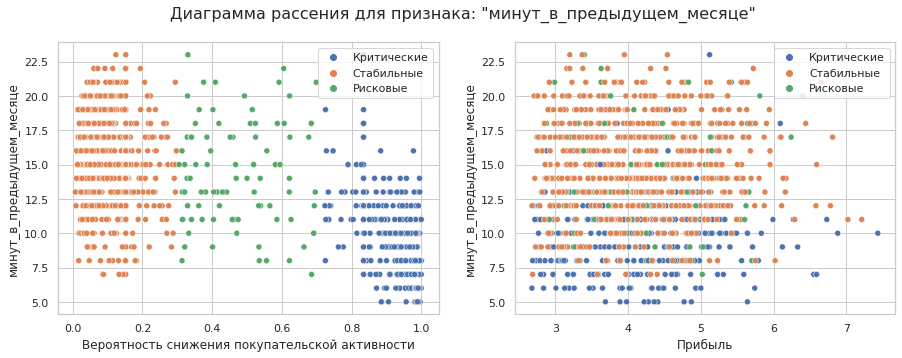


Группировка по признаку: минут_в_предыдущем_месяце
             count       mean       std  min   25%   50%   75%   max
сегмент                                                             
Критические  365.0  10.008219  2.809411  5.0   8.0  10.0  11.0  23.0
Рисковые      92.0  14.282609  3.710176  7.0  11.0  14.0  17.0  23.0
Стабильные   709.0  15.100141  3.346701  7.0  13.0  15.0  18.0  23.0



In [ ]:
segments_scatter('минут_в_предыдущем_месяце')

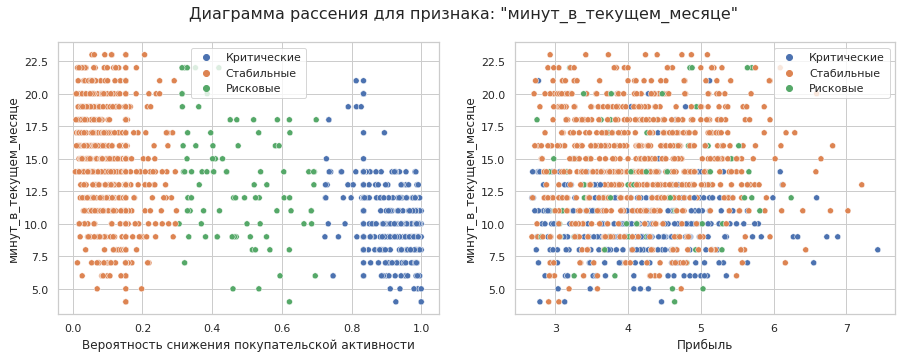


Группировка по признаку: минут_в_текущем_месяце
             count       mean       std  min   25%   50%   75%   max
сегмент                                                             
Критические  365.0  10.298630  2.862436  4.0   9.0  10.0  12.0  21.0
Рисковые      92.0  13.195652  4.196385  4.0  10.0  13.0  16.0  22.0
Стабильные   709.0  14.726375  4.014964  4.0  12.0  15.0  18.0  23.0



In [ ]:
segments_scatter('минут_в_текущем_месяце')

Аналогично со временем, проведённым на сайте, причем для предыдущего периода тенденция более ярко выражена.

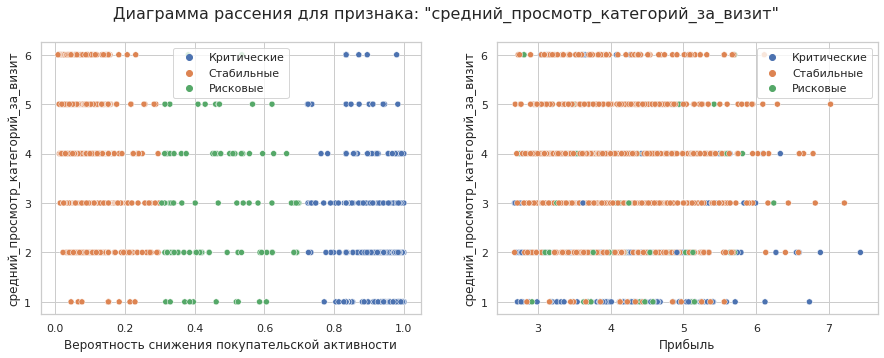


Группировка по признаку: средний_просмотр_категорий_за_визит
             count      mean       std  min  25%  50%  75%  max
сегмент                                                        
Критические  365.0  2.512329  1.175756  1.0  2.0  2.0  3.0  6.0
Рисковые      92.0  2.913043  1.263626  1.0  2.0  3.0  4.0  6.0
Стабильные   709.0  3.677010  1.278370  1.0  3.0  4.0  5.0  6.0



In [ ]:
segments_scatter('средний_просмотр_категорий_за_визит')

Описательная статистика показывает, что среди стабильных клиентов `средний просмотр категорий за визит` выше, чем у рисковых, а у критических самый низкий.

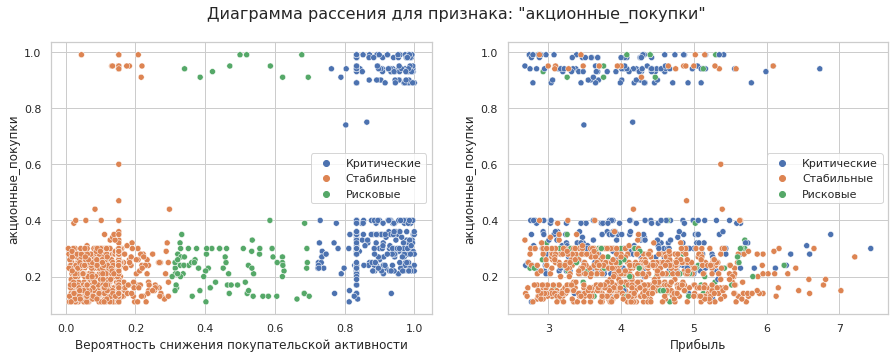


Группировка по признаку: акционные_покупки
             count      mean       std   min   25%   50%   75%   max
сегмент                                                             
Критические  365.0  0.492027  0.306345  0.11  0.25  0.34  0.90  0.99
Рисковые      92.0  0.307174  0.233254  0.11  0.18  0.24  0.30  0.99
Стабильные   709.0  0.229803  0.144841  0.11  0.15  0.21  0.25  0.99



In [ ]:
segments_scatter('акционные_покупки')

Среди клиентов, предпочитающих покупать товары по акции, наиболее высока доля критически рисковых покупателей.  
25% пользователей из сегмента критических совершают по акции от 90% покупок.  
Следовательно, данный сегмент покупателей сильно привязан к действующим акциям: пока есть выгодные предложения, они совершают покупки, а затем, когда акция заканчивается, они перестают активно покупать товары.

### Промежуточный вывод

Для исследования были исключены из рассмотрения 10% наименее прибыльных клиентов, а затем выделены три сегмента в зависимости от риска сокращения покупательской активности:  
- `стабильные`;  
- `рисковые`;  
- `критические`.   

Для анализа быд выбран сегмент `критических` клиентов, поскольку у них наиболее высокая вероятность снижения активности, но при этом достаточно большие значения прибыли. Рассматривался сегмент в сравнении с другими группами покупателей.  

Для работы с данным сегментом можно рассмотреть введение программ лояльности с бонусами за каждую покупку, которые можно использовать при последующих заказах. Это может стимулировать клиентов, предочитающих товары по акции, к более частым покупкам. Помимо этого можно оптимизировать работу сайта с точки зрения удобства и эффективности поиска товаров, поскольку сайт оказался наиболее важным аспектом, влияющим на поведение пользователей. Добавление персонализированных подборок товаров на основе предыдущих покупок и просматриваемых категорий, также, может повысить интерес к другим товарам и таким образом стимулировать покупательскую активность.

## Общий вывод

Интернет-магазин ***В один клик*** столкнулся со снижением покупательской активности, при этом привлечение новых клиентов стало неэффективным, поскольку большая часть целевой аудитории уже знает о магазине. Необходимо повысить активность постоянных клиентов посредством персонализированных предложений.  

**Задача:** разработать решение для персонализации предложений постоянным клиентам.  

Были предоставлены 4 набора данных, отражающих:  
- поведение покупателей на сайте;  
- выручка от каждого клиента;  
- время, проведённое на сайте;  
- прибыль от каждого клиента.  

При предобработке и исследовательском анализе данных были обнаружены и решены следующие проблемы:  
- переименованы признаки (приведены к нижнему регистру, и удалены пробелы),  
- изменены типы данных,  
- устранены явлные дубликаты,  
- удалено аномальное значение для выручки.  

Для поиска оптимальной модели был построен пайплайн для подготовки данных (кодирования категориальных признаков и масштабирования количественных) и выбора лучшей модели путём перебора способов масштабирования и гипепараметров моделей (kNN, SVM, логистической регрессии, дерева решений). Для перебора использовался RandomizedSearchCV().  

Лучшей оказалась модель SVM (метод опорных векторов) с гиперпараметрами: C=9, probability=True, random_state=42.  

Для более детального анализа был выделен сегмент критически рисковых клиентов (прибыль выше 10 процентиля и вероятность снижения покупательской активности не менее 70%). Результаты исследования показали, что `время проведённое на сайте`, `количество страниц, просматриваемых за визит`, `количество категорий, просматриваемвых за визит` обратно пропорционально связаны с вероятностью снижения покупательской активности, то еть: чем больше времени клиент проводит на сайте (больше категорий или страниц просматривает), тем меньше вероятность, что покупательская активность пользователя сократится. В связи с этим целесообразно оптимизировать сайт с целью сокращения времени, необходимого для поиска товара: если клиент будет быстро находить товары - более вероятно, что он найдёт товар, который захочет купить, до того, как решит покинуть сайт.  
Помимо этого имеет смысл добавить персонализированные рекомендации товаров на основе предыдущих товаров и просматриваемых категорий.  
Также в ходе анализа была обнаружена группа клиентов, предпочитающих покупать `товары по акции`, вероятность снижения активности таких покупателей наиболее высока, поэтому следует рассмотреть возможность разработки программ лояльности с бонусами за каждую покупку, которые можно использовать при последующих заказах или разработка специальных акций и скидок, основанных на предыдущих покупках и предпочтениях клиентов.